In [196]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [197]:
#Create functions.

#Function that creates an 'observation' of the different light curve models by taking the magnitudes 
#corresponding to 24 hour cadence starting from 0.5 days.
def make_lightcurve(t, mod):
    mag = np.zeros(len(t)) 
    for ind,i in enumerate(t):
        a = np.interp(i, model[mod][:,0], model[mod][:,1])
        mag[ind] = a
    return(mag)

#Function that scales these magnitudes with distance so that they are within a range of the expected 30% error in
#the distance parameter from the GW source.
def make_scale_model(mag, rand_dist_range):
    mag_scale=[]
    for i in range(len(rand_dist_range)):
        obs = mag + 5*np.log10((rand_dist_range[i])/(dist_all_models)) #this comes from m-M = 5log(d) - 5
        mag_scale.append(obs)
    return(mag_scale)

#Function that introduces an error of ±0.25 onto the magnitudes that would come from the optical telescope.
def introduce_telescope_err(mag_scale):
    corrected_mags = []
    rand_err = np.random.uniform(-0.25, 0.25, len(mag_scale[0]))
    for mags in mag_scale:
        corrected_mags.append(mags + rand_err) #adds same 14 errors to the 14 magnitudes of all the scaled models.
    return(corrected_mags)

#Function to create a chi squared distribution.
def make_chi_squared(mag_err, mag, cutoff_mag):
    all_chi2 = []
    for mags in mag_err:
        num = np.where(mags > cutoff_mag)[0]
        if len(num) > 10:
            chi2 = 10000
        else:
            remove_ind = np.logical_not(mags>cutoff_mag)
            mags = mags[remove_ind] #remove elements that have a magnitude greater than cutoff mag.
            kn = mag[0][remove_ind] #removes elements from reference magnitues so arrays are equal sizes.
            chi2 = np.sum(np.square(mags - kn)/kn)
        all_chi2.append(chi2)
    return(all_chi2)

#Function to return a dictionary with the minimmum chi value and the model related to this minimum chi value.
def return_best_model(dictionary):
    min_chi2_models = np.ones(len(dictionary)) #creates an array of ones with the length of the dict.
    for i in range(0,len(dictionary)):
        min_chi2_models[i] = min(dictionary[str(i)]) #appends values of dictionary (in string form) to ones array.
    val = min_chi2_models.min() #finds the minimum chisquared value in the model.
    ind = min_chi2_models.argmin() #finds the model where this lowest value lies.
    return(val, ind)

In [198]:
#Load in models.

lc = np.load('light_curves.npz')
m0 = lc['two']
m1 = lc['two_r']
m2 = lc['two_b']
m3 = lc['three']
m4 = lc['three_b']
m5 = lc['KW']
m6 = lc['BR']
m7 = lc['GW']

#Define parameters.

N = 1000 #number of kn models in Universe.

model = [m0, m1 ,m2 ,m3 ,m4 ,m5 ,m6 ,m7] #array of all the kn models.
time = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5] #cadence of the observations in days.

dist = np.random.uniform(40,200,N) #Mpc #creates random distance between 40-200 Mpc (range we expect to detect KN).
dist_all_models = 40 #Mpc #reference distance when scaling the magnitudes.
low_dist_err = 0.7 #min distance from the 30% error range.
high_dist_err = 1.3 #max distance from the 30% error range.

cutoff_mag = 21 #GOTO will not be able to observe anything beyond (fainter) this magnitude.

#Conditions for a match to use in the cumulative sum.
match = 1 
non_match = 0

In [199]:
#Simulating N kilonova models in the universe.

#List of empty arrays used to append values in the loop.
array_kns = []
all_kn_distance = []
model_distance = []
min_chi2 = []
best_model = []
ind_chi2 = []
dist_ind_value = []

for j in range(N):
    
    #Create kn in universe.
    
    x = np.random.randint(0, 8) #chooses a random model out of the 8.
    gen_kn = make_lightcurve(time, x) #universe creates 'observation' of model with magnitudes taken at cadences.
    kn = make_scale_model(gen_kn, [dist[j]]) #places this observation model at a random distance.
    
    print([dist[j]]) #ERROR WITH [dist[j]] and then propogates forward! But it changes, sometimes it gives me what 
                     #I want and I see distances around 200ish but when I run it again, it caps it at 139. It 
                     #always works the first time I run it and then it definitley overwrites it if I only run 
                     #certain sections and dont run it all again
    
    #Record model of kn chosen to store in dictionary later.
    array_kns.append(x)
    
    #Work out step of model over distance to give a range between min and max 30% error range.
    dist_range = np.arange(np.floor(low_dist_err*dist[j]), np.ceil(high_dist_err*dist[j]), 1)
    
    print(dist_range) #fine here after ran for the first time but propogates when not
    
    #Use functions defined and loop them over all models.
    chisquare_models = []
    for i in range(len(model)):
        magnitude = make_lightcurve(time, i) #inserting model number from 0-7 (models 1-8) and times for cadenece.
        scale = make_scale_model(magnitude, dist_range) #inserting the returned 'mag' from previous magnitude 
                                                        #function and the distance range to scale models over.
        error = introduce_telescope_err(scale) #inserting the scaled magnitudes from the scale function.
        chisquare = make_chi_squared(error, kn, cutoff_mag) #inserting the corrected magnitudes and the magnitudes
                                                            #from the original kn model.
        chisquare_models.append(chisquare) #appending the chisquare values for each of the 8 models.
        
    #Save chisquared data for each model in a dictionary.
    chi_dict = {'0':chisquare_models[0], '1':chisquare_models[1], '2':chisquare_models[2], '3':chisquare_models[3], '4':chisquare_models[4], '5':chisquare_models[5], '6':chisquare_models[6], '7':chisquare_models[7]}
    
    #Using return best model function to find min chi and best model fit for all the models over every iteration.
    return_best_model(chi_dict)
    lowest_chi = return_best_model(chi_dict)[0]
    related_model = return_best_model(chi_dict)[1]
    min_chi2.append(lowest_chi)
    best_model.append(related_model)
    
    #Finding the index of the minimum chi value to find out where the distance of the model is.
    chi_index_min = np.argmin(chisquare_models[int(related_model)]) #finds index of min chisquare value in models.
    ind_chi2.append(chi_index_min)
    print(chi_index_min)
    dist_range_index = dist_range[int(chi_index_min)] #puts index of min chi into distance to get a value.
    dist_ind_value.append(dist_range_index)
    
    #Looping over dist_all_models N times for kn_info dict.
    all_kn_distance.append(int(dist[j]))

[129.93995824731653]
[ 90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168.]
0
[72.04246279418723]
[50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67.
 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85.
 86. 87. 88. 89. 90. 91. 92. 93.]
8
[62.08026219421406]
[43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60.
 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80.]
15
[106.38411299353832]
[ 74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 

9
[166.96915472697734]
[116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.
 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213.
 214. 215. 216. 217.]
0
[104.35206472226088]
[ 73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135.]
25
[136.1773268753195]
[ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112.

26
[173.8007741557522]
[121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134.
 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148.
 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162.
 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176.
 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190.
 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204.
 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218.
 219. 220. 221. 222. 223. 224. 225.]
0
[162.3247088702637]
[113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 

20
[150.42230600472772]
[105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195.]
0
[111.6487806251464]
[ 78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.]
14
[69.9154286969682]
[48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 7

0
[197.98275351860093]
[138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.
 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.
 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221.
 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235.
 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249.
 250. 251. 252. 253. 254. 255. 256. 257.]
0
[106.17603405397297]
[ 74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138.]
1
[111.272102

17
[175.91881950682568]
[123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220.
 221. 222. 223. 224. 225. 226. 227. 228.]
0
[169.98542131546805]
[118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199

8
[132.4387242190398]
[ 92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.]
4
[118.91550865403698]
[ 83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154.]
3
[114.00549120480527]
[ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 

0
[167.53595951676587]
[117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217.]
0
[99.10115131866972]
[ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128.]
28
[185.93736683376915]
[130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151.

0
[168.4885712302153]
[117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218. 219.]
0
[95.60813387942117]
[ 66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124.]
14
[86.33376614477444]
[ 60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  

0
[167.97359153363075]
[117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218.]
0
[74.73929105619175]
[52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.
 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87.
 88. 89. 90. 91. 92. 93. 94. 95. 96. 97.]
7
[154.01113188430784]
[107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134.
 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148.
 149. 150. 1

13
[91.32813990997357]
[ 63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.
  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.]
30
[105.0762059020926]
[ 73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136.]
23
[136.76154359234667]
[ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157.

[42.02123457204333]
[29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48. 49. 50. 51. 52. 53. 54.]
13
[46.44170200564302]
[32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.
 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60.]
15
[79.3548975642244]
[ 55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103.]
22
[57.25020828832493]
[40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74.]
18
[64.57230459769141]
[45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62.
 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80.
 81. 82. 83.]
18
[90.08638281654308]
[ 63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.
  77.  78.  79. 

0
[81.59825691532639]
[ 57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106.]
38
[196.75702312869052]
[137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220.
 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234.
 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248.
 249. 250. 251. 252. 253. 254. 255.]
0
[174.81606244493452]
[122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.


0
[161.30462913867265]
[112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209.]
0
[65.0912725616976]
[45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62.
 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80.
 81. 82. 83. 84.]
14
[178.2688315377415]
[124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.
 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 17

33
[98.21869465432117]
[ 68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127.]
18
[197.97970224981387]
[138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.
 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.
 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221.
 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235.
 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249.
 250. 251. 252. 253. 254. 255. 256. 257.]
0
[131.01500686585064]
[ 91.  92.  93

0
[70.87484760572394]
[49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66.
 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84.
 85. 86. 87. 88. 89. 90. 91. 92.]
15
[58.87582114700962]
[41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.
 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.]
11
[106.85264225816059]
[ 74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138.]
24
[160.44306337838913]
[112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 

0
[167.99053767200354]
[117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218.]
0
[143.44621820427665]
[100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141.
 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155.
 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169.
 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183.
 184. 185

7
[81.84826325035714]
[ 57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106.]
8
[198.30567960022188]
[138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165.
 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.
 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221.
 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235.
 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249.
 250. 251. 252. 253. 254. 255. 256. 257.]
0
[147.05146369789554]
[102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 1

12
[150.9696295687566]
[105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195. 196.]
0
[90.47133570872771]
[ 63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.
  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.]
2
[145.85969792992688]
[102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 1

0
[68.32318677554096]
[47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.
 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82.
 83. 84. 85. 86. 87. 88.]
22
[83.73712473931157]
[ 58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 105. 106. 107. 108.]
7
[194.3343626876329]
[136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.
 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163.
 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177.
 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191.
 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205.
 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219.
 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233.
 234

0
[88.2285531132196]
[ 61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.]
3
[114.84689971186042]
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
11
[99.5145505359709]
[ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128

9
[181.11247201522647]
[126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209.
 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223.
 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235.]
0
[185.0514594148666]
[129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 

0
[186.0671682734556]
[130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.
 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213.
 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227.
 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241.]
0
[111.17840978186047]
[ 77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.]
15
[128.65037362975372]
[ 90.  91.  92. 

13
[187.64718795701495]
[131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228.
 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242.
 243.]
0
[175.74537844036962]
[123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 19

0
[154.992395219998]
[108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.
 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163.
 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177.
 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191.
 192. 193. 194. 195. 196. 197. 198. 199. 200. 201.]
0
[75.98380984366378]
[53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93. 94. 95. 96. 97. 98.]
24
[95.67704444171349]
[ 66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.

0
[82.28229614705859]
[ 57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106.]
25
[79.67126095695116]
[ 55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103.]
36
[155.99914982850038]
[109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.


 244. 245.]
0
[58.87841167130611]
[41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.
 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.]
14
[86.52787742730654]
[ 60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.]
31
[120.05499657165628]
[ 84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156.]
2
[80.21787560402822]
[ 56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  

0
[93.22109754065673]
[ 65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121.]
18
[77.59101215091366]
[ 54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100.]
13
[147.48159779716156]
[103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181.

0
[170.51278047485607]
[119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202.
 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216.
 217. 218. 219. 220. 221.]
0
[68.71822794823521]
[48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89.]
26
[131.42262344398318]
[ 91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 1

0
[96.23006222520333]
[ 67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125.]
20
[61.14330862303046]
[42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77.
 78. 79.]
13
[113.138226312191]
[ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134.
 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.]
9
[147.2347941854514]
[103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 1

0
[64.75005152653141]
[45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62.
 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80.
 81. 82. 83. 84.]
17
[182.04364518004616]
[127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196.
 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210.
 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224.
 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235. 236.]
0
[69.24512809747874]
[48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90.]
22
[198.5121665815614]
[138. 139.

 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.]
0
[179.11933619060613]
[125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194.
 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208.
 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222.
 223. 224. 225. 226. 227. 228. 229. 230. 231. 232.]
0
[61.30681204212298]
[42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77.
 78. 79.]
21
[50.33840319890018]
[35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
17
[136.33896415050376]
[ 95.  96.  97.  98

 183. 184.]
0
[111.38760564379778]
[ 77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.]
19
[106.42487163047076]
[ 74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138.]
17
[142.06298198748235]
[ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 1

12
[166.27459345486756]
[116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.
 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213.
 214. 215. 216.]
0
[85.19148852555486]
[ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.]
18
[88.61945126540446]
[ 62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.

 156. 157. 158. 159. 160.]
4
[94.49290558613987]
[ 66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122.]
5
[66.3408147931704]
[46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.
 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81.
 82. 83. 84. 85. 86.]
22
[170.24649801360044]
[119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202.
 203. 204. 205. 206. 

13
[45.455347433483]
[31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.
 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]
7
[54.643879878349736]
[38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]
20
[132.07350821749003]
[ 92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.]
0
[100.37983686212681]
[ 70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 

13
[91.7573514057195]
[ 64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
13
[46.02752994095431]
[32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.
 50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]
7
[42.287191844056395]
[29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48. 49. 50. 51. 52. 53. 54.]
13
[186.49978996127305]
[130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199.
 200. 201. 202. 203. 204. 205. 206. 207. 208. 

0
[61.31750813825825]
[42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77.
 78. 79.]
19
[69.56435414973643]
[48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90.]
21
[139.5927298203822]
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181.]
0
[158.07804314604851]
[110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 1

27
[79.09399827188321]
[ 55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102.]
0
[140.86767130686223]
[ 98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183.]
0
[93.09318719186173]
[ 65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 

In [200]:
print(max(dist_ind_value)) # HERE is where the error is I think? 
print(dist_ind_value) # the code is putting index of min chi into distance to get a value.

139.0
[90.0, 58.0, 58.0, 88.0, 40.0, 110.0, 61.0, 94.0, 58.0, 115.0, 92.0, 119.0, 93.0, 88.0, 89.0, 90.0, 92.0, 129.0, 108.0, 95.0, 90.0, 44.0, 115.0, 117.0, 121.0, 134.0, 63.0, 116.0, 98.0, 97.0, 88.0, 99.0, 105.0, 45.0, 50.0, 135.0, 100.0, 85.0, 136.0, 134.0, 97.0, 47.0, 118.0, 96.0, 117.0, 128.0, 48.0, 120.0, 64.0, 88.0, 121.0, 113.0, 115.0, 95.0, 86.0, 70.0, 98.0, 78.0, 87.0, 81.0, 120.0, 110.0, 63.0, 85.0, 77.0, 79.0, 125.0, 117.0, 92.0, 59.0, 42.0, 87.0, 105.0, 92.0, 55.0, 125.0, 50.0, 133.0, 56.0, 46.0, 92.0, 96.0, 55.0, 110.0, 72.0, 90.0, 117.0, 56.0, 94.0, 109.0, 46.0, 123.0, 37.0, 95.0, 97.0, 122.0, 64.0, 92.0, 136.0, 95.0, 138.0, 75.0, 96.0, 73.0, 87.0, 70.0, 58.0, 105.0, 91.0, 138.0, 98.0, 124.0, 54.0, 111.0, 111.0, 66.0, 64.0, 134.0, 112.0, 103.0, 83.0, 91.0, 38.0, 65.0, 94.0, 123.0, 118.0, 137.0, 68.0, 63.0, 120.0, 102.0, 57.0, 96.0, 103.0, 81.0, 114.0, 137.0, 119.0, 97.0, 106.0, 84.0, 97.0, 105.0, 77.0, 92.0, 114.0, 64.0, 92.0, 92.0, 96.0, 86.0, 80.0, 79.0, 42.0, 90.0, 5

In [201]:
print(all_kn_distance) #again fine for first time but after ran seperately its not. This is the distance for all
                       #the models?

[129, 72, 62, 106, 47, 158, 61, 111, 65, 165, 116, 171, 123, 106, 119, 107, 104, 184, 154, 116, 128, 45, 165, 168, 173, 192, 77, 166, 104, 136, 97, 116, 151, 46, 50, 194, 143, 77, 195, 191, 96, 44, 168, 137, 168, 182, 45, 172, 81, 89, 173, 162, 165, 128, 112, 64, 98, 105, 125, 102, 171, 157, 86, 122, 101, 95, 178, 168, 100, 66, 42, 95, 150, 111, 69, 178, 50, 191, 63, 45, 106, 120, 71, 158, 68, 129, 168, 69, 95, 156, 49, 175, 50, 113, 139, 174, 92, 117, 195, 137, 197, 106, 111, 58, 124, 66, 59, 151, 92, 197, 141, 178, 42, 158, 159, 51, 75, 192, 160, 148, 108, 125, 41, 64, 111, 175, 169, 196, 66, 62, 172, 145, 72, 137, 148, 109, 163, 196, 170, 138, 152, 110, 139, 150, 91, 93, 163, 66, 104, 120, 132, 118, 114, 110, 53, 110, 52, 59, 120, 66, 157, 166, 108, 99, 60, 136, 107, 96, 177, 162, 62, 168, 61, 144, 62, 100, 188, 167, 99, 185, 81, 65, 77, 57, 108, 66, 110, 48, 166, 40, 77, 165, 77, 137, 129, 98, 185, 65, 85, 59, 94, 154, 116, 199, 168, 95, 86, 58, 146, 146, 81, 153, 130, 100, 127, 60

In [202]:
#Save KN, best fit model, min chi2 value, model distance (use indexing to find lowest) and KN distance)

kn_info = {'KN model':array_kns, 'Best fit model':best_model, 'Minimum Chi2':min_chi2, 'Model distance':dist_ind_value, 'KN distance':all_kn_distance}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


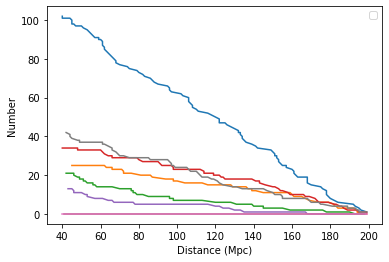

In [210]:
#Create an efficiency curve.

#Turning arrays into numpy arrays.
array_kns = np.asarray(array_kns)
best_model = np.asarray(best_model)

plt.figure()

for i in range(0,len(model)):
    kn_mod = kn_info['KN model']
    best_fit = kn_info['Best fit model']
    kn_dist = kn_info['KN distance']
    
    kn_mod = np.asarray(kn_mod)
    best_fit = np.asarray(best_fit)
    kn_dist = np.asarray(kn_dist)
    
    kn_ind = np.where(kn_mod==i)[0] #finds the indicies where the kn model is model i (i.e. 0 and then 1, ect.)
    best_ind = best_fit[kn_ind] #puts these indicies into the best fit model to find whether the theoretical and 
                                #best fit models are the same at the same index point.
    match_dist = np.zeros(len(kn_ind))
    cumulative = np.zeros(len(kn_ind))

    #HERE I USED KN INSTEAD OF MODEL DISTANCE.
    
    for j in range(0,len(kn_ind)):
        match_dist[j] = kn_dist[kn_ind[j]] #appends distance of relating KN model to an array.
        if best_ind[j] == i: #if value of best fit model is same as value of kn ind then match and add 1. 
            cumulative[j] = match
        else: #if value of best fit model is not the same as value of kn ind then non-match and add nothing.
            cumulative[j] = non_match

    cumsum = np.cumsum(cumulative)[::-1] #makes a cumulative sum and reverses it.
    plot_dist = np.sort(match_dist) #orders distances.
    
    #label = 'model %s' % i, 'injections %s' % len(kn_ind[i]) #label different model numbers and states number of 
                                                             #injections.
    #norm = np.arange(0,1
    
    plt.plot(plot_dist, cumsum)#, label=label)
    plt.legend()
    plt.ylabel('Number')
    plt.xlabel('Distance (Mpc)')

plt.show()